<a href="https://colab.research.google.com/github/ymz1529/p300test/blob/main/notebook-scripts/CNN1(%E8%83%BD%E5%85%A8%E9%83%A8%E8%B7%91%E9%80%9A%E7%89%88%E6%9C%AC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN1 SETTINGS

SUBJECT'S DATA SELECTION:                                                                                                  
- **A**: Signal samples: 7794, EEG channels: 64, Testset letters: 100                                                           
- **B**: Signal samples: 7794, EEG channels: 64, Testset letters: 100

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from scipy.io import loadmat
from scipy import signal
from google.colab import drive
import warnings
import string
import os

from keras.layers import *
from keras.models import Model
from keras import backend as K
from keras import Sequential
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

# Install mne library for topoplot
!pip install mne
import mne

warnings.filterwarnings('ignore')
drive.mount('/content/drive')

####################### SETTINGS ########################
# Set this variable with the desidered subject's letter #
SUBJECT_SELECTED = "B"                                  #
#########################################################

subject_names = ["A", "B"]

# Check for errors in the settings
if SUBJECT_SELECTED not in subject_names:
    raise ValueError("SUBJECT_SELECTED value {} is invalid.\nPlease enter one of the following parameters {}".format(SUBJECT_SELECTED, subject_names))

# Google drive data paths
MODEL_LOCATIONS_FILE_PATH = 'drive/My Drive/AY1920_DT_P300_SPELLER_03/Trained_models/CNN1/' + SUBJECT_SELECTED
SUBJECT_TRAIN_FILE_PATH = 'drive/My Drive/AY1920_DT_P300_SPELLER_03/Dataset/Subject_' + SUBJECT_SELECTED + '_Train.mat'
SUBJECT_TEST_FILE_PATH = 'drive/My Drive/AY1920_DT_P300_SPELLER_03/Dataset/Subject_' + SUBJECT_SELECTED + '_Test.mat'
CHANNEL_LOCATIONS_FILE_PATH = 'drive/My Drive/AY1920_DT_P300_SPELLER_03/Dataset/channels.csv'
CHANNEL_COORD = 'drive/My Drive/AY1920_DT_P300_SPELLER_03/Dataset/coordinates.csv'

# Channel selection
CHANNELS = [i for i in range(64)]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.8 MB/s eta 0:00:00
Mounted at /content/drive


# Training set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Down-sampling signals from 240Hz to 120Hz;
3.   Obtain windows of 650ms at the start of every flashing (175ms)
4.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
5.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 78, 64)**;
6.   Obtain **(noP300 / P300)** class ratio to balance out dataset during training;

In [2]:
# 加载训练数据集，并打印出一些基本信息
if not os.path.exists(SUBJECT_TRAIN_FILE_PATH):
    print("Missing file: {}".format(SUBJECT_TRAIN_FILE_PATH))
else:
    # Load the required data
    data = loadmat(SUBJECT_TRAIN_FILE_PATH)
    # Get the variables of interest from the loaded dictionary
    signals = data['Signal']
    flashing = data['Flashing']
    stimulus = data['StimulusType']
    word = data['TargetChar']

    SAMPLING_FREQUENCY = 240
    # From the dataset description we know that there are 15 repetitions
    REPETITIONS = 15
    # Compute the duration of the recording in minutes
    RECORDING_DURATION = (len(signals))*(len(signals[0]))/(SAMPLING_FREQUENCY*60)
    # Compute number of trials
    TRIALS = len(word[0])
    # Set flag to True to balance the training set
    BALANCE_DATASET = False

    print("**********************************")
    print("       TRAIN SET INFORMATION      ")
    print("**********************************")
    print("Sampling Frequency: %d Hz [%.2f ms]" % (SAMPLING_FREQUENCY, (1000/SAMPLING_FREQUENCY)))
    print("Session duration:   %.2f min" % RECORDING_DURATION)
    print("Number of letters:  %d" % TRIALS)
    print("Spelled word:       %s" % ''.join(word))

**********************************
       TRAIN SET INFORMATION      
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   46.01 min
Number of letters:  85
Spelled word:       VGREAAH8TVRHBYN_UGCOLO4EUERDOOHCIFOMDNU6LQCPKEIREKOYRQIDJXPBKOJDWZEUEWWFOEBHXTQTTZUMO


In [3]:
# Application of butterworth filter 对EEG信号应用巴特沃斯滤波器，以滤除不在特定频率范围内的噪声
b, a = signal.butter(4, [0.1/SAMPLING_FREQUENCY, 20/SAMPLING_FREQUENCY], 'bandpass')
for trial in range(TRIALS):
    signals[trial, :, :] = signal.filtfilt(b, a, signals[trial, :, :], axis=0)

In [4]:
# Down-sampling of the signals from 240Hz to 120Hz 这段代码用于将EEG信号从240Hz下采样到120Hz，并打印下采样前后的样本数
DOWNSAMPLING_FREQUENCY = 120
SCALE_FACTOR = round(SAMPLING_FREQUENCY / DOWNSAMPLING_FREQUENCY)
SAMPLING_FREQUENCY = DOWNSAMPLING_FREQUENCY

print("# Samples of EEG signals before downsampling: {}".format(len(signals[0])))

signals = signals[:, 0:-1:SCALE_FACTOR, :]
flashing = flashing[:, 0:-1:SCALE_FACTOR]
stimulus = stimulus[:, 0:-1:SCALE_FACTOR]

print("# Samples of EEG signals after downsampling: {}".format(len(signals[0])))

# Samples of EEG signals before downsampling: 7794
# Samples of EEG signals after downsampling: 3897


In [6]:
# Number of EEG channels 从EEG信号中提取特征和标签，用于训练模型
N_CHANNELS = len(CHANNELS)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(SAMPLING_FREQUENCY * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
SAMPLES_PER_TRIAL = len(signals[0])

train_features = []
train_labels = []

count_positive = 0
count_negative = 0

for trial in range(TRIALS):
    for sample in (range(SAMPLES_PER_TRIAL)):
        if (sample == 0) or (flashing[trial, sample-1] == 0 and flashing[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals[trial, lower_sample:upper_sample, :]
            # Features extraction
            train_features.append(window)
            # Labels extraction
            if stimulus[trial, sample] == 1:
                count_positive += 1
                train_labels.append(1) # Class P300
            else:
                count_negative += 1
                train_labels.append(0) # Class no-P300

# Get negative-positive classes ratio
train_ratio = count_negative/count_positive

# Convert lists to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

# 3D Tensor shape (SAMPLES, 64, 78)
dim_train = train_features.shape
print("Features tensor shape: {}".format(dim_train))

Features tensor shape: (15300, 78, 64)


In [7]:
# Data normalization Zi = (Xi - mu) / sigma 对训练特征数据进行归一化处理
for pattern in range(len(train_features)):
    train_features[pattern] = scale(train_features[pattern], axis=0)

# Testing set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Down-sampling signas from 240Hz to 120Hz;
3.   Obtain windows of 650ms at the start of every flashing (175ms)
4.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
5.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 78, 64)**;
6.   Calculate weights vector to balance samples importance and obtain correct accuracy estimation;

In [9]:
# Test data loading 加载测试数据集，并打印出一些基本信息
if not os.path.exists(SUBJECT_TEST_FILE_PATH):
    print("Missing file: {}", SUBJECT_TEST_FILE_PATH)
else:
    # Load the required data
    data_test = loadmat(SUBJECT_TEST_FILE_PATH)
    # Get the variables of interest from the loaded dictionary
    signals_test = data_test['Signal']
    flashing_test = data_test['Flashing']
    word_test =  data_test['TargetChar']
    stimulus_code_test = data_test['StimulusCode']

    SAMPLING_FREQUENCY = 240
    # From the dataset description we know that there are 15 repetitions
    REPETITIONS = 15
    # Compute the duration of the recording in minutes
    RECORDING_DURATION_TEST = (len(signals_test))*(len(signals_test[0]))/(SAMPLING_FREQUENCY*60)
    # Compute number of trials
    TRIALS_TEST = len(word_test[0])
    # Number of samples for each character in trials
    SAMPLES_PER_TRIAL_TEST = len(signals_test[0])

    print("**********************************")
    print("        TEST SET INFORMATION      ")
    print("**********************************")
    print("Sampling Frequency: %d Hz [%.2f ms]" % (SAMPLING_FREQUENCY, (1000/SAMPLING_FREQUENCY)))
    print("Session duration:   %.2f min" % RECORDING_DURATION_TEST)
    print("Number of letters:  %d" % TRIALS_TEST)
    print("Spelled word:       %s" % ''.join(word_test))  # 将目标字符列表连接成字符串并打印

**********************************
        TEST SET INFORMATION      
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   54.12 min
Number of letters:  100
Spelled word:       MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR


In [10]:
# Create characters matrix 创建一个字符矩阵和一个刺激类型数组 stimulus_test，该数组表示测试集中每个试验的每个样本是否为目标字符
char_matrix = [[0 for j in range(6)] for i in range(6)]
s = string.ascii_uppercase + '1' + '2' + '3' + '4' + '5' + '6' + '7' + '8' + '9' + '_'

# Append cols and rows in a list
list_matrix = []
for i in range(6):
    col = [s[j] for j in range(i, 36, 6)]
    list_matrix.append(col)
for i in range(6):
    row = [s[j] for j in range(i * 6, i * 6 + 6)]
    list_matrix.append(row)

# Create StimulusType array for the test set (missing from the given database)
stimulus_test = [[0 for j in range(SAMPLES_PER_TRIAL_TEST)] for i in range(TRIALS_TEST)]
stimulus_test = np.array(stimulus_test)

for trial in range(TRIALS_TEST):
    counter=0
    for sample in range(SAMPLES_PER_TRIAL_TEST):
        index = int(stimulus_code_test[trial, sample]) - 1
        if not index == -1:
            if word_test[0][trial] in list_matrix[index]:
                stimulus_test[trial, sample] = 1
            else:
                stimulus_test[trial, sample] = 0

In [11]:
# Application of butterworth filter 对测试集中的EEG信号应用巴特沃斯滤波器，以滤除不在特定频率范围内的噪声
b, a = signal.butter(4, [0.1/SAMPLING_FREQUENCY, 20/SAMPLING_FREQUENCY], 'bandpass')
for trial in range(TRIALS_TEST):
    signals_test[trial, :, :] = signal.filtfilt(b, a, signals_test[trial, :, :], axis=0)

In [12]:
# Down-sampling of the signals from 240Hz to 120Hz 下采样
DOWNSAMPLING_FREQUENCY = 120
SCALE_FACTOR = round(SAMPLING_FREQUENCY / DOWNSAMPLING_FREQUENCY)
SAMPLING_FREQUENCY = DOWNSAMPLING_FREQUENCY

print("# Samples of EEG signals before downsampling: {}".format(len(signals_test[0])))

signals_test = signals_test[:, 0:-1:SCALE_FACTOR, :]
flashing_test = flashing_test[:, 0:-1:SCALE_FACTOR]
stimulus_test = stimulus_test[:, 0:-1:SCALE_FACTOR]

print("# Samples of EEG signals after downsampling: {}".format(len(signals_test[0])))

# Samples of EEG signals before downsampling: 7794
# Samples of EEG signals after downsampling: 3897


In [13]:
# Number of EEG channels 从测试集中提取特征和标签，并计算测试权重
N_CHANNELS = len(CHANNELS)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(SAMPLING_FREQUENCY * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
SAMPLES_PER_TRIAL_TEST = len(signals[0])

test_features = []
test_labels = []
windowed_stimulus = []

count_positive = 0
count_negative = 0

for trial in range(TRIALS_TEST):
    for sample in (range(SAMPLES_PER_TRIAL_TEST)):
        if (sample == 0) or (flashing_test[trial, sample-1] == 0 and flashing_test[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals_test[trial, lower_sample:upper_sample, :]
            # Extracting number of row/col in a window
            number_stimulus = int(stimulus_code_test[trial, sample])
            windowed_stimulus.append(number_stimulus)
            # Features extraction
            test_features.append(window)
            # Labels extraction
            if stimulus_test[trial, sample] == 1:
                count_positive += 1
                test_labels.append(1) # Class P300
            else:
                count_negative += 1
                test_labels.append(0) # Class no-P300

# Get test weights to take into account the number of classes
test_weights = []
for i in range(len(test_labels)):
    if test_labels[i] == 1:
        test_weights.append(len(test_labels)/count_positive)
    else:
        test_weights.append(len(test_labels)/count_negative)
test_weights = np.array(test_weights)

# Convert lists to numpy arrays
test_features = np.array(test_features)
test_labels = np.array(test_labels)

# 3D tensor (SAMPLES, 64, 78)
dim_test = test_features.shape
print("Features tensor shape: {}".format(dim_test))

Features tensor shape: (18000, 78, 64)


In [14]:
# Data normalization Zi = (Xi - mu) / sigma 归一化
for pattern in range(len(test_features)):
    test_features[pattern] = scale(test_features[pattern], axis=0)

# CNN1 model definition, training and testing

1.   Function definiton for randomization of weights and biases;
2.   **Scaled_tanh(x)** activation function definition;
3.   ANN model definition (2 Conv1D layers, 2 dense layers);
4.   Training of the network over weighted dataset;
5.   CNN1 performance assessment;

In [20]:
# Randomizing function for bias and weights of the network # 随机化权重和偏置的函数
import tensorflow as tf

def cecotti_normal(shape, dtype = None, partition_info = None):
    if len(shape) == 1:
        fan_in = shape[0]
    elif len(shape) == 2:
        fan_in = shape[0]
    else:
        receptive_field_size = 1
        for dim in shape[:-2]:
            receptive_field_size *= dim
        fan_in = shape[-2] * receptive_field_size
    return tf.random.normal(shape, mean = 0.0, stddev = (1.0 / fan_in))

In [29]:
# Custom tanh activation function # 自定义激活函数
import tensorflow.keras.backend as K
def scaled_tanh(z):
    return 1.7159 * K.tanh((2.0 / 3.0) * z)

In [18]:
# Build the model # CNN1模型定义
def CNN1_model(channels=64, filters=10):
    model = Sequential([
        Conv1D(
            filters = filters,
            kernel_size = 1,
            padding = "same",
            bias_initializer = cecotti_normal,
            kernel_initializer = cecotti_normal,
            use_bias = True,
            activation = scaled_tanh,
            input_shape = (78, channels)
        ),
        Conv1D(
            filters = 50,
            kernel_size = 13,
            padding = "valid",
            strides = 11,
            bias_initializer = cecotti_normal,
            kernel_initializer = cecotti_normal,
            use_bias = True,
            activation = scaled_tanh,
        ),
        Flatten(),
        Dense(100, activation="sigmoid"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    return model

In [21]:
# Training parameters
BATCH_SIZE = 256   # 每个批次的样本数量
EPOCHS = 200  # 训练的总轮数（epoch）
VALID_SPLIT = 0.05  # 用于验证的数据集比例
SHUFFLE = 1 # set to 1 to shuffle subsets during training

# Model summary
CNN1_model(channels=64, filters=10).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 78, 10)              │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 6, 50)               │           6,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,401 (146.10 KB)

 Trainable params: 37,401 (146.10 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# 创建CNN1模型实例。
# 设置一个ModelCheckpoint回调函数来保存训练过程中的最佳模型。
# 设置一个EarlyStopping回调函数来防止过拟合，如果验证集上的损失在指定的epoch数内没有改善，则停止训练。
# 训练模型，并传入训练特征、标签、批次大小、训练轮数、验证集比例、回调函数列表、是否打乱数据集以及类别权重。
# class_weight参数用于处理类别不平衡问题，通过为不同的类别分配不同的权重来提高模型对少数类的识别能力。

# Model definition
model = CNN1_model(channels=64, filters=10)

# Callback to save best model only
checkpoint = ModelCheckpoint(filepath=MODEL_LOCATIONS_FILE_PATH + "/" + "model" + ".weights.h5",
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True
                             )

# Callback to stop when loss on validation set doesn't decrease in 50 epochs
earlystop = EarlyStopping(monitor = 'val_loss',
                              mode = 'min',
                              patience = 50,
                              restore_best_weights = True)

# Callback to keep track of model statistics
history = model.fit(x=train_features,
                    y=train_labels,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=VALID_SPLIT,
                    callbacks=[checkpoint, earlystop],
                    shuffle=SHUFFLE,
                    class_weight={0: 1., 1: train_ratio})

model.save(MODEL_LOCATIONS_FILE_PATH + "/" + "model.h5")

Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.4981 - loss: 0.4118 - val_accuracy: 0.6379 - val_loss: 0.2182
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6907 - loss: 0.3407 - val_accuracy: 0.7686 - val_loss: 0.1629
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7485 - loss: 0.2903 - val_accuracy: 0.7556 - val_loss: 0.1638
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7690 - loss: 0.2712 - val_accuracy: 0.8013 - val_loss: 0.1506
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7780 - loss: 0.2663 - val_accuracy: 0.8052 - val_loss: 0.1429
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7700 - loss: 0.2747 - val_accuracy: 0.7699 - val_loss: 0.1565
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7719 - loss: 0.2691 - val_accuracy: 0.7843 - val_loss: 0.1501
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7762 - loss: 0.2635 - val_accuracy: 0.7725 - 

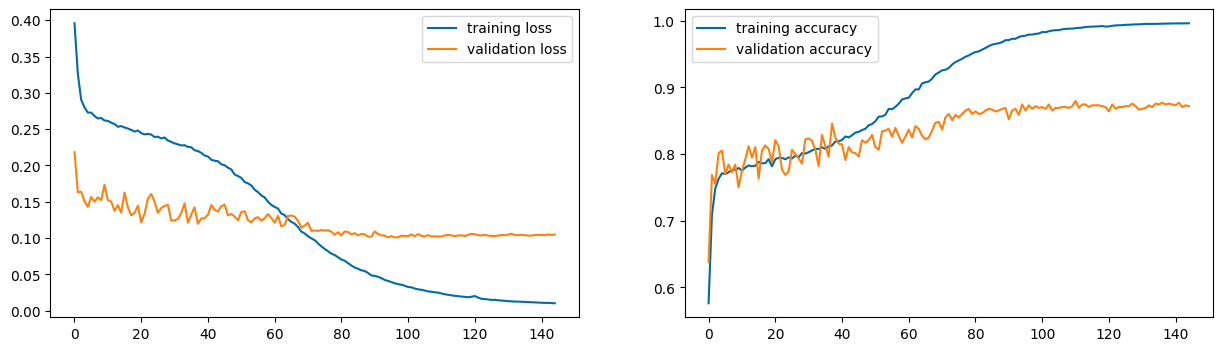

In [33]:
# 绘制训练过程中的损失曲线和准确率曲线
plt.figure(figsize=(15,4))
plt.style.use('tableau-colorblind10')

# Plots of loss curves during training
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()

# Plots of accuracy curves during training
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="training accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.legend()

plt.show()

In [34]:
# Define model
best_model = CNN1_model(channels=64, filters=10)

# Load best model weights from h5 file
best_model.load_weights(MODEL_LOCATIONS_FILE_PATH + "/model.h5")

# Compile best model model
best_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

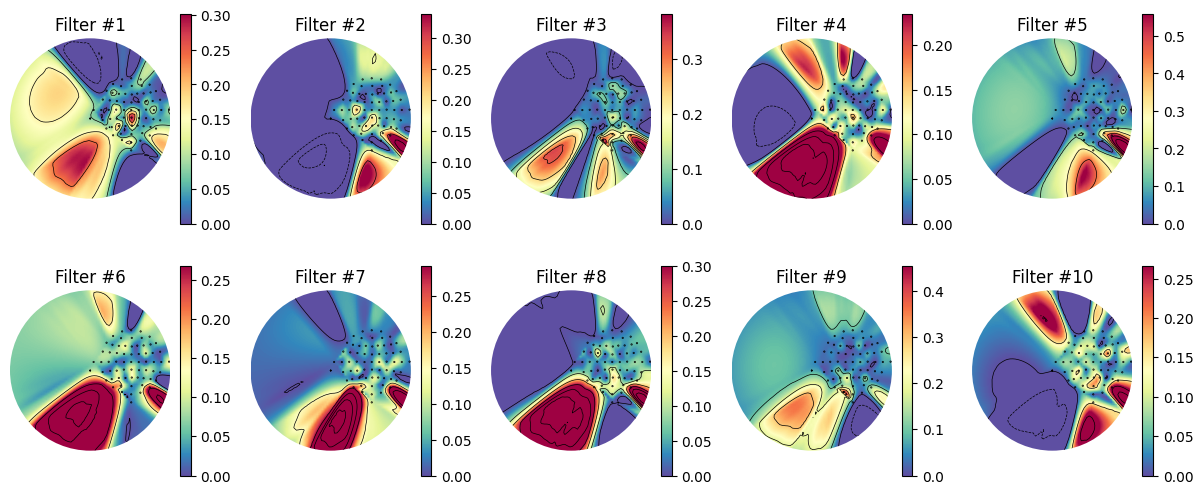

In [44]:
# Load topoplot coordinates 加载电极坐标、创建权重列表，并绘制第一个卷积层中10个滤波器的topoplot
# Check for file existence
if not os.path.exists(CHANNEL_COORD):
    print("Missing file: {}".format(CHANNEL_COORD))
else:
    xycoord = []
    # Read file content
    try:
        with open(CHANNEL_COORD, "r") as f:
            file_content = f.read()
            # Loop over all rows
            for row in file_content.split("\n"):
                if row == '':  # Skip empty rows
                    continue
                xycoord.append(row)
    except FileNotFoundError:
        print("File not found: {}".format(CHANNEL_COORD))

# Create a list with x,y coordinates of each electrode
coord = []
for x in xycoord:
    coord.append([float(i) for i in x.split(',')])  # Convert to float
coord = np.array(coord)

# Flip y axis
for i in range(len(coord)):
    coord[i][1] = 681 - int(coord[i][1])

# Create a list of weights for all filters
nf = []
for filt in range(10):
    nf.append(abs(np.array(best_model.get_weights()[0])[0, :, filt]))
nf = np.array(nf, dtype=float)

# Plot topomap of the 10 filters in the first convolutional layer
fig = plt.figure(figsize=(15,6))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    ax.set_title("Filter #{}".format(i+1))
    im, _ = mne.viz.plot_topomap(nf[i], coord, cmap='Spectral_r', axes=ax, show=False)
    fig.colorbar(im, ax=ax)

plt.show()

In [45]:
# Accuracy over the testing set 评估模型在测试集上的性能
predictions = best_model.predict(test_features)
predictions = np.round(predictions)

score = np.array(best_model.evaluate(test_features, test_labels, verbose=0, sample_weight=test_weights))
print("Model performance on test set:\t[ Loss: {}\tAccuracy: {} ]".format(*score.round(4)))
print("\nPredictions: {}\nSolutions:   {}".format(list(map(int, predictions))[:50], list(map(int, test_labels))[:50]))

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Model performance on test set:	[ Loss: 0.4866	Accuracy: 0.8255 ]

Predictions: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
Solutions:   [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]


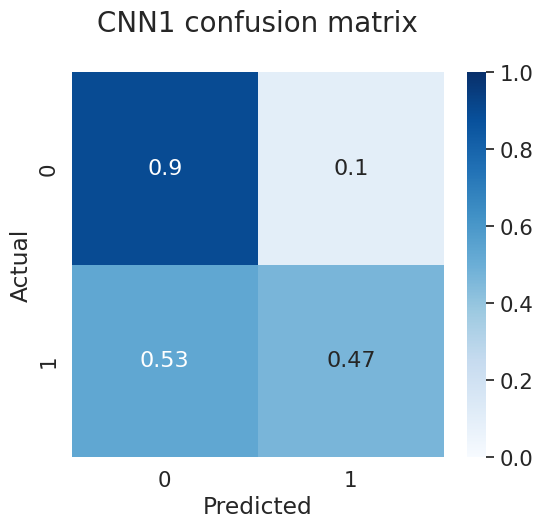

In [46]:
# Weighted confusion matrix (noP300: 80%, P300: 20%) 于计算加权混淆矩阵，并将其归一化，然后绘制归一化混淆矩阵的热图
data = confusion_matrix(y_true=test_labels, y_pred=predictions, sample_weight=test_weights)

# Normalized confusion matrix (values in range 0-1)
data_norm = data/np.full(data.shape, len(test_labels))

# Plot the confusion matrix
df_cm = pd.DataFrame(data_norm, columns=np.unique(test_labels), index = np.unique(test_labels))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,5))
sns.set(font_scale = 1.4)
cm = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws = {"size": 16}, vmin=0, vmax=1)
cm.axes.set_title("CNN1 confusion matrix\n", fontsize=20)
plt.show()

In [47]:
# 用于从归一化的混淆矩阵中计算和返回模型的四个关键性能指标：敏感性（Sensitivity）、特异性（Specificity）、阳性预测值（Positive Predicted Value, PPV）和阴性预测值（Negative Predicted Value, NPV）
# Model metrics (sens, spec, ppv, npv)

def model_metrics(conf_matrix):
    tn, fp, fn, tp = list(data_norm.flatten())
    sens = round(tp/(tp+fn),4) # Sensitivity
    spec = round(tn/(tn+fp),4) # Specificity
    ppv = round(tp/(tp+fp),4) # Positive Predicted Value
    npv = round(tn/(tn+fn),4) # Negative Predicted Value
    return {"Sensitivity":sens, "Specificity":spec, "PPV":ppv, "NPV":npv}

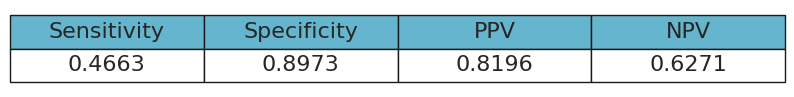

In [50]:
# Put model metrics into a table 将模型度量指标放入一个表格中，并创建一个图形来显示这个表格
metrics = model_metrics(data_norm)

# Create figure
fig = plt.figure(figsize=(5,1))
ax = fig.add_subplot(111)

# Hide graph outlines
for item in [fig, ax]:
    item.patch.set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

# Table definition
table = ax.table(cellText=[list(metrics.values())],
                     colLabels=list(metrics.keys()),
                     loc="center",
                     cellLoc="center",
                     colColours=["c"]*4)
table.set_fontsize(16)
table.scale(2,2)

plt.show()